In [24]:
import numpy as np
from arch import arch_model
import numpy as np
from scipy import optimize
from scipy.stats import norm
from scipy import special
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
import matplotlib.pyplot as plt

## Read in data

In [11]:
import pandas as pd

In [12]:
daily_sp500_returns = pd.read_fwf("daily_sp500_ret.txt").to_numpy()[4:]
monthly_sp500_returns = pd.read_fwf("monthly_sp500_ret.txt").to_numpy()[4:]

In [13]:
sp500_monthly_garch_model_11 = arch_model(monthly_sp500_returns[:,1], vol='Garch', p=1, o=0, q=1)
sp500_monthly_garch_fitted = monthly_garch_model_11.fit()

NameError: name 'monthly_garch_model_11' is not defined

In [ ]:
sp500_monthly_garch_fitted.params

# Problem 4

In [14]:
def simulate_euler_CIR(kappa, theta, sigma2, nsteps):
    dt = 1/250.0
    rates = np.zeros(nsteps)
    rates[0] = theta
    noise = np.random.normal(0, np.sqrt(dt), size=nsteps)
    for t in range(1, nsteps):
        rates[t] = abs(rates[t-1] + kappa*(theta - rates[t-1])*dt + np.sqrt(sigma2*rates[t-1])*noise[t])
    return rates

In [15]:
rates = simulate_euler_CIR(kappa=0.234, theta=0.081, sigma2=0.0073, nsteps=100000)

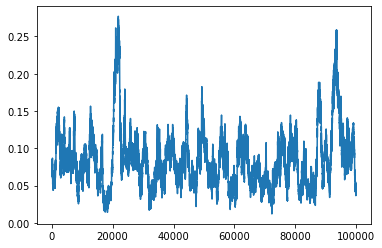

In [16]:
plt.plot(rates)

In [17]:
monthly_rates = rates[::250]
monthly_rates.shape

(400,)

$$\epsilon_{k+1} - E{\epsilon_{k+1}|F_k} = 0$$
$$r_{k+1} - r_k - \kappa(\theta - r_t) \delta_k = 0$$

In [18]:

# define moment functions

def g1(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return data[1:] - data[:-1] - kappa*(theta - data[:-1])*dt

def g2(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return data[:-1]*g1(pv, data)

def g3(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return (g1(pv, data))**2 - sig2*data[:-1]*dt

def g4(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return data[:-1] * g3(pv, data) - sig2*(data[:-1]**2)*dt

In [19]:
def GMM(moments, param_vect, data, n_iter=1):
    results = []
    W = np.eye(len(moments))
    
    def G(W):
        def inner(pv):
            moment_means = np.mean(np.array([g(pv, data) for g in moments]), axis=1)
            retval = moment_means @ W @ moment_means
            return retval
        return inner
    
    res = optimize.minimize(G(W), x0 = param_vect, method = 'BFGS', tol = 1.e-9)
    
    res = res.x
    results.append(res.copy())
    for _ in range(n_iter):
        
        S = np.zeros_like(W)
        for t in range(data.shape[0]-1):
            moments_t = np.array([g(res, data[t:t+2]) for g in moments])
            
            S += np.outer(moments_t, moments_t)
        S /= (data.shape[0]-1)
        moment_means = np.array([np.mean(g(res, data)) for g in moments])
        S -= np.outer(moment_means, moment_means)
        W = np.linalg.inv(S)
        res = optimize.minimize(G(W), x0 = param_vect, method = 'BFGS', tol = 1.e-9)
        res=res.x
        results.append(res.copy())
    return results

In [20]:
theta_init = 0.1 #np.mean(monthly_rates)
kappa_init = 0.1 #0.234
sig2_init = 0.1 #0.0073
opt_input = [theta_init, kappa_init, sig2_init]

In [25]:
results = GMM([g1, g2, g3, g4], opt_input, monthly_rates, n_iter=10)

In [26]:
results

[array([0.08315011, 0.17488929, 0.00578323]),
 array([0.07308134, 0.22172589, 0.00273418]),
 array([0.06746998, 0.2333932 , 0.00103607]),
 array([0.06363814, 0.211677  , 0.00075267]),
 array([0.06209988, 0.20260548, 0.00080989]),
 array([0.06174568, 0.20174722, 0.00081742]),
 array([0.0616399 , 0.20167805, 0.00081786]),
 array([0.06160264, 0.20166484, 0.00081786]),
 array([0.06158915, 0.20166007, 0.00081786]),
 array([0.06158426, 0.20165829, 0.00081786]),
 array([0.06158249, 0.20165764, 0.00081786])]

In [27]:
def QML_G(data):
    def qml(pv):
        theta, kappa, sig2 = pv
        lik = 0
        for i in range(data.shape[0]-1):
            lik += norm.logpdf(data[i + 1], data[i] + kappa*(theta - data[i]), 
                        np.sqrt(abs(sig2) * data[i]))
        return -lik
    return qml

In [28]:
optimize.minimize(QML_G(monthly_rates), x0 = [0.1, 0.1, 0.1])  # looks good: hess_inv is our covariance matrix

      fun: -973.8431804454634
 hess_inv: array([[ 3.07367275e-05, -2.46350382e-04, -1.30351290e-07],
       [-2.46350382e-04,  1.98817701e-03,  3.73514100e-07],
       [-1.30351290e-07,  3.73514100e-07,  1.73118615e-07]])
      jac: array([7.62939453e-06, 3.05175781e-05, 3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 266
      nit: 13
     njev: 64
   status: 2
  success: False
        x: array([0.08322254, 0.20302147, 0.0058607 ])

In [29]:
yts = 2 * np.sqrt(monthly_rates)

In [38]:
def SO_lik(yts):
    def like(pv):
        theta, kappa, sig2 = pv
        A = (2/yts[:-1])*(kappa*theta - (sig2)/4) - kappa*(yts[:-1])/2 
        B = (-2/(yts[:-1]**2)) * (kappa*theta - (sig2)/4) - kappa/2
        C = (4/(yts[:-1]**3)) * (kappa*theta - (sig2)/4)

        K = np.exp(B) - 1

        M = yts[:-1] + (A/B)*K + ((sig2) * C)/(2 * (B**2))*(K - B)
        V = (sig2)/(2*B) * (np.exp(2*B) - 1)

        lik = 0
        for i in range(yts.shape[0] -1):
            lik -= -((yts[i + 1] - M[i])**2) / (2*V[i]) - (1/2)*np.log(2*np.pi*V[i])
        return lik
    return like

In [39]:
optimize.minimize(SO_lik(yts), x0 = [0.1, 0.1, 0.1],
                  bounds = [(0.0, 1), (0.0, 1), (1e-15, 1)], tol = 1.e-14)

      fun: -465.9819700723568
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.13686838e-05,  3.41060513e-05,  5.40012479e-04])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 220
      nit: 16
     njev: 55
   status: 2
  success: False
        x: array([0.08311736, 0.23470817, 0.00717133])

In [40]:
SO_lik(yts)([0.05, 0.1, 0.05**2])

-318.5878083933145

In [41]:
SO_lik(yts)([0.08311736, 0.23470817, 0.00717133])

-465.98197007223746